In [2]:
from preprocessing import generate_dataset
import numpy as np
import matplotlib.pyplot as plt

# Where the satellites are (usually)? Do they have a distribution? 
Most probably not, but I am curious

In [5]:
sats_coord, nb_of_sats, features = generate_dataset(sequence_id_list=range(1, 500), path="../data", max_num_of_sats=3, padding_value=-1)

path: ../data/train_anno.json
features: (2080, 480, 640) -- nb_of_sats: (2080,) -- sats_coord: (2080, 3, 2)


In [6]:
print(sats_coord[0:3,:, :])
sats_coord = sats_coord.astype(np.int16)
print(sats_coord[0:3,:, :])

[[[502.40625    237.11458333]
  [490.38183594 221.81152344]
  [140.87433155 129.09358289]]

 [[530.40625    214.11458333]
  [518.38183594 198.81152344]
  [167.85995989 107.87800802]]

 [[558.40625    191.11458333]
  [546.38183594 175.81152344]
  [195.19050802  85.93516043]]]
[[[502 237]
  [490 221]
  [140 129]]

 [[530 214]
  [518 198]
  [167 107]]

 [[558 191]
  [546 175]
  [195  85]]]


In [4]:
sats_coord_new = sats_coord.reshape(-1, 2)
print(sats_coord_new.shape)

(6240, 2)


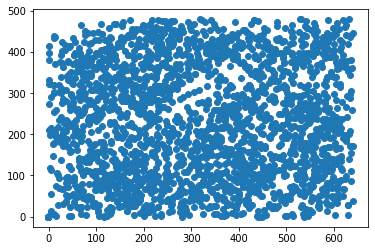

In [5]:
fig, axis = plt.subplots(1, 1)
axis.plot(sats_coord_new[:, 0], sats_coord_new[:, 1], 'o')
plt.show()

In [6]:
np.count_nonzero(sats_coord_new[:, 0] == -1)

3920

In [7]:
print(np.count_nonzero(nb_of_sats))

1455


In [8]:
print(np.max(sats_coord[:, :, 0]))
print(np.max(sats_coord[:, :, 1]))

639.16845703125
479.0115966796875


## Conclusion
* Nothing special in general. 
* Maybe more interesting to look at frames of each sequence alone, instead of all of them at once
    * I am expecting each satellite will follow a line or an arc, moving from one frame to another, something systematic

# Regression
Here, I will apply a naive RF regressor. I will not standardize the data for now - I think this a direct problem, but I am too tired right now, and there is too much to think about.

In [1]:
from preprocessing import generate_dataset
import numpy as np
import matplotlib as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy.ma as ma

In [22]:
# Load the data
sats_coord, nb_of_sats, features = generate_dataset(sequence_id_list=range(1, 1000), path="../data", max_num_of_sats=3, padding_value=-1)
sats_coord = sats_coord.astype(np.int16)

features = features.reshape(features.shape[0], -1)
sats_coord = sats_coord.reshape(sats_coord.shape[0], -1)
mask_value = sats_coord == -1

# Standard scaling both inputs and outputs
features = MinMaxScaler(feature_range=(0, 1)).fit_transform(features)
sats_coord = MinMaxScaler(feature_range=(0, 1)).fit_transform(sats_coord)

path: ../data/train_anno.json
features: (4250, 480, 640) -- nb_of_sats: (4250,) -- sats_coord: (4250, 3, 2)


In [23]:
# split the data
sats_coord_train, sats_coord_test, nb_of_sats_train, nb_of_sats_test, features_train, features_test, mask_value_train, mask_value_test = train_test_split(sats_coord, nb_of_sats, features, mask_value, test_size=0.1)

In [26]:
model = RandomForestRegressor(n_jobs=10, n_estimators=10, verbose=10, max_depth=30)

In [27]:
model.fit(features_train, sats_coord_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 10building tree 2 of 10
building tree 3 of 10
building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10building tree 9 of 10

building tree 10 of 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 19.9min remaining: 46.5min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 20.3min remaining: 20.3min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 21.2min remaining:  9.1min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 21.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=10,
                      oob_score=False, random_state=None, verbose=10,
                      warm_start=False)

In [28]:
train_prediction = model.predict(features_train)
train_prediction_masked = train_prediction[~mask_value_train]
sats_coord_train_masked = sats_coord_train[~mask_value_train]
train_r2_score = r2_score(sats_coord_train_masked, train_prediction_masked)
train_mse_score = mean_squared_error(sats_coord_train_masked, train_prediction_masked)

print(f'Train --> MSE: {train_mse_score} \t\t R2: {train_r2_score}')

Train --> MSE: 0.024446085642011985 		 R2: 0.6898543359308984


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [29]:
test_prediction = model.predict(features_test)
print(test_prediction.shape)
test_prediction_masked = test_prediction[~mask_value_test]
print(test_prediction_masked.shape)
sats_coord_test_masked = sats_coord_test[~mask_value_test]
test_r2_score = r2_score(sats_coord_test_masked, test_prediction_masked)
test_mse_score = mean_squared_error(sats_coord_test_masked, test_prediction_masked)

print(f'Test --> MSE: {test_mse_score} \t\t R2: {test_r2_score}')

(425, 6)
(960,)
Test --> MSE: 0.12176654563075923 		 R2: -0.5133569571256604


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
